In [1]:
library(rlang)
library(repr)
library(tidyverse)
options(repr.plot.width=8, repr.plot.height=4)
library(xtable)
library(latex2exp)
library("dplyr")
library(RCTdesign)
library(ggplot2)

Warning message:
“package ‘rlang’ was built under R version 3.4.4”Warning message:
“package ‘repr’ was built under R version 3.4.4”── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0.9000     ✔ purrr   0.2.5     
✔ tibble  2.0.1          ✔ dplyr   0.7.8     
✔ tidyr   0.8.1          ✔ stringr 1.3.1     
✔ readr   1.1.1          ✔ forcats 0.3.0     
Warning message:
“package ‘tibble’ was built under R version 3.4.4”Warning message:
“package ‘tidyr’ was built under R version 3.4.4”Warning message:
“package ‘purrr’ was built under R version 3.4.4”Warning message:
“package ‘dplyr’ was built under R version 3.4.4”Warning message:
“package ‘stringr’ was built under R version 3.4.4”Warning message:
“package ‘forcats’ was built under R version 3.4.3”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%@%()         masks rlang::%@%()
✖ purrr::%||%()        masks rlang::%||%()
✖ purrr::as_function() masks rlang::a

In [23]:
f <- function(x, var=0){
    y <- (x-3)^2 + 10
    if(var==0){
        return(y)
    }else{
        return(y + rnorm(length(x), mean=0, sd=sqrt(var)))
    }
}
rlim <- 6
x <- seq(0, rlim, 0.1)
f.var <- 20

In [24]:
signal.to.noise <- var(f(x))/(f.var)
signal.to.noise

[1] 0.3904915

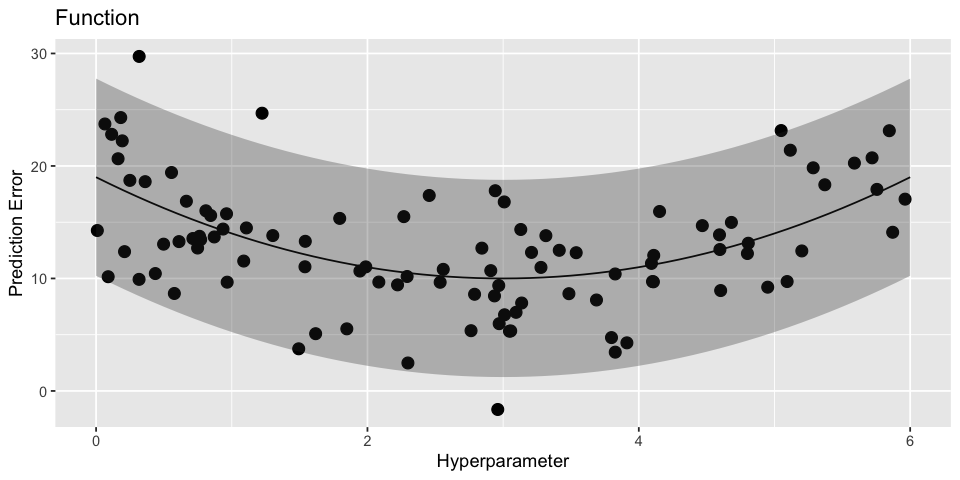

In [25]:
xeval <- runif(100, 0, rlim)
function.df <- data.frame(x=x, y=f(x), lwr=f(x)-1.96*sqrt(f.var), upr=f(x)+1.96*sqrt(f.var))
points.df <- data.frame(x=xeval, y=f(xeval, var=f.var))
p <- ggplot(points.df, aes(x=x, y=y))+
    labs(x="Hyperparameter", y = "Prediction Error", title="Function")+
    geom_point(aes(), size=3)+
    geom_line(data=function.df)+
    geom_ribbon(data=function.df,aes(ymin=lwr,ymax=upr),alpha=0.3)+
    theme(legend.position="none")
p

In [17]:
N <- 50
n <- 10
x <- runif(N/n, min=0, max=rlim)
X <- matrix(rep(x,each=n),nrow=n)
Y <- f(X, var=1)
colnames(Y) <- X[1,]
result.df <- gather(as.data.frame(Y)) %>% rename(Objective=value, x=key)
result.df$x <- as.numeric(result.df$x)
group.df <- result.df %>% 
                group_by(x) %>% 
                summarise(ObservedMean=mean(Objective)) %>% 
                arrange(ObservedMean)
selected.x <- group.df[1,]$x

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”

In [18]:
GetResult <- function(N, n, f.var){
    x <- runif(N/n, min=0, max=rlim)
    X <- matrix(rep(x,each=n),nrow=n)
    Y <- f(X, var=f.var)
    colnames(Y) <- X[1,]
    result.df <- gather(as.data.frame(Y)) %>% rename(Objective=value, x=key)
    result.df$x <- as.numeric(result.df$x)
    group.df <- result.df %>%
                    group_by(x) %>% 
                    summarise(ObservedMean=mean(Objective)) %>% 
                    arrange(ObservedMean)
    selected.x <- group.df[1,]$x
}

In [19]:
N <- 50
f.var <- c(0.5, 1, 5, 10, 20)
results <- data.frame(f.var=c(f.var, f.var),
                      n=rep(NA, 2*length(f.var)),
                      mse=rep(NA, 2*length(f.var)),
                      mean.epe=rep(NA, 2*length(f.var)),
                      var.epe=rep(NA, 2*length(f.var)))
num_sim <- 100

for(j in 1:length(f.var)){
    x.1 <- rep(NA, num_sim)
    x.5 <- rep(NA, num_sim)
    for(i in 1:num_sim){
        x.1[i] <- GetResult(N=N, n=1, f.var=f.var[j])
        x.5[i] <- GetResult(N=N, n=5, f.var=f.var[j])
    }
    results[j,]$n <- 1
    results[j,]$mse <- mean((x.1 - 3)^2)
    results[j,]$mean.epe <- mean(f(x.1))
    results[j,]$var.epe <- var(f(x.1))
    
    results[j+length(f.var),]$n <- 5
    results[j+length(f.var),]$mse <- mean((x.5 - 3)^2)
    results[j+length(f.var),]$mean.epe <- mean(f(x.5))
    results[j+length(f.var),]$var.epe <- var(f(x.5))
}

# results
df <- filter(results, n==1) %>% inner_join(filter(results, n==5), by='f.var')


In [20]:
df$signal.to.noise <- var(f(x))/df$f.var

In [21]:
df

f.var,n.x,mse.x,mean.epe.x,var.epe.x,n.y,mse.y,mean.epe.y,var.epe.y,signal.to.noise
0.5,1,0.2230617,10.22306,0.07653568,5,0.2077907,10.20779,0.1005856,19.1727360
1.0,1,0.2102981,10.21030,0.04600202,5,0.2868714,10.28687,0.1317316,9.5863680
5.0,1,0.4267231,10.42672,0.37239718,5,0.3716824,10.37168,0.2188024,1.9172736
10.0,1,0.7370416,10.73704,0.83136569,5,0.5823932,10.58239,0.5064572,0.9586368
20.0,1,1.1027456,11.10275,1.86362009,5,0.6064924,10.60649,0.9121208,0.4793184
